# EE4211 Project - Question 3  Proposal


Group number: Group No.21

Group mumbers:Zhou Ying A0229575R, Wang Shi Cheng A0206245M

It will take some time to finish running.

And there will be some pre-experiments using singel data befor deriving the final results. Please kindly read the annotations.

## Proposal

In our previous proposal, we plan to discuss whether the gas companies adjusted the price of natural gas during extreme circumstances and how they adjusted it. And  we assume that the price of gas price will be affected by the weather.

But actually, we didnt get an exact and continuous data of natural gas price, so in this part, we just discuss the change of usage during different weather. 



### Introduction 
#### Firstly, we make a cluster and label the data using K-means classifier, and find one representative meterid from each cluster.
#### Secondly, we analyse the relationship between weather changes and natural gas usage of representative meterid

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets, linear_model

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [2]:
data = pd.read_csv("/Users/zhouying/Desktop/dataport-export_gas_oct2015-mar2016.csv")
df = pd.DataFrame(data)

In [3]:
#change to datetime format
df['localminute'] = df['localminute'].map(lambda x: str(x)[0:-3])
df['localminute'] = pd.to_datetime(df['localminute'], infer_datetime_format=True)

In [4]:
def select_monthdata(df, month, meter_id):
    df_month = df[df.localminute.dt.month.isin([month])]
    grouped = df_month.groupby('dataid')
    data1 = grouped.get_group(meter_id)
    day_value_list = []
    month_dict = {1:31,2:29,3:31,4:30,5:31,6:30,7:31,8:31,9:30,10:31,11:30,12:31} 
    #create a month dictionary and support that how many days in each month
    
    for d in np.arange(1, month_dict[month] + 1):
        #loop through each day in the list
        day_data = data1[data1.localminute.dt.day.isin ([d])]
        value = list(day_data.meter_value[-1:])
        day_value_list.append(value)
    
    day_data = pd.DataFrame(day_value_list,columns = ['value'])
    day_data = day_data.fillna(method = 'ffill')    #fill the vacant with the previous data.
    day_data = day_data.fillna(method = 'bfill')    #fill the vacant with its following data.
    return day_data

In [5]:
# group the data
grouped = df.groupby('dataid')

In [6]:
# get the actual month list of the selected meter(for some meters they didnt have a 6-month recording)
gpdata = grouped.get_group(35)
group_month = gpdata.groupby(df.localminute.dt.month)
month_list = []
for name,group in group_month:
    if name < 10:       # after 'groupby' the return data will be sorted and changed their orginal order.  
        name += 12      # the month in year 2016 will +12 to keep the order.
    month_list.append(name)
month_list_sort = list(np.sort(month_list))

In [7]:
month_list = []
for i in month_list_sort:
    if i > 12:
        i -= 12
    month_list.append(i)

In [8]:
def get_day_data(meter_id):
    
    day_data = pd.DataFrame()
    d_month = pd.DataFrame()
    
    for month in month_list:
        d = select_monthdata(df, month, meter_id)
        d_month = pd.concat([d_month,d],axis = 0)
    day_data = pd.concat([day_data,d_month], axis=1)
    
    return day_data

In [9]:
key = 35
day_data = get_day_data(key) # get hourly data of the selected meter.

In [10]:
day_data 

,value
0,93484.0
1,93522.0
2,93550.0
3,93588.0
4,93624.0
...,...
26,104504.0
27,104556.0
28,104606.0
29,104644.0


In [11]:
grouped_id = []
grouped = df.groupby('dataid')
for name,group in grouped:
    grouped_id.append(name)

In [12]:
lack_id = []
for name,group in grouped:
    for i in month_list:
        t = group[group.localminute.dt.month == i]
        if not len(t):
            lack_id.append(name)
        lack_meter = np.unique(lack_id)
print('meters that report no readings for at least one month are: \n ',lack_meter)
re_id = []
for i in grouped_id:
    if i not in lack_meter:
        re_id.append(i)
print('meters to calculate Correlation: \n', re_id)

meters that report no readings for at least one month are: 
  [1103 1403 2638 2645 2755 2814 2946 3036 4352 4421 4447 4671 4874 5317
 5545 5658 6101 6578 6673 6685 6863 7460 7566 7919 8244 8386 8467 8703
 9160 9474 9600 9620 9956]
meters to calculate Correlation: 
 [35, 44, 77, 94, 114, 187, 222, 252, 370, 483, 484, 661, 739, 744, 871, 1042, 1086, 1185, 1283, 1415, 1507, 1556, 1589, 1619, 1697, 1714, 1718, 1790, 1791, 1792, 1800, 1801, 2018, 2034, 2072, 2094, 2129, 2233, 2335, 2378, 2449, 2461, 2470, 2575, 2818, 2945, 2965, 2980, 3039, 3134, 3310, 3367, 3527, 3544, 3577, 3635, 3723, 3778, 3849, 3893, 3918, 4029, 4031, 4193, 4228, 4296, 4356, 4373, 4514, 4732, 4767, 4998, 5129, 5131, 5193, 5275, 5395, 5403, 5439, 5484, 5636, 5785, 5810, 5814, 5892, 5972, 6412, 6505, 6830, 6836, 6910, 7016, 7017, 7030, 7117, 7287, 7429, 7674, 7682, 7739, 7741, 7794, 7900, 7965, 7989, 8059, 8084, 8086, 8155, 8156, 8829, 8890, 8967, 9052, 9121, 9134, 9278, 9295, 9631, 9639, 9729, 9766, 9849, 9982]


In [13]:
all_day_data = pd.DataFrame()
for name in re_id:
    day_data = get_day_data(name)
    all_day_data = pd.concat([all_day_data ,day_data], axis=1)
all_day_data.columns = re_id

In [14]:
day_usage = np.diff(all_day_data.T,axis = 1)
day_usage = pd.DataFrame(day_usage, index = [re_id])
day_usage

,0,1,2,3,4,5,6,7,8,9,...,172,173,174,175,176,177,178,179,180,181
35,38.0,28.0,38.0,36.0,32.0,46.0,16.0,8.0,8.0,8.0,...,94.0,56.0,22.0,64.0,64.0,82.0,52.0,50.0,38.0,48.0
44,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
77,14.0,12.0,18.0,30.0,20.0,28.0,20.0,24.0,8.0,28.0,...,40.0,40.0,32.0,28.0,42.0,38.0,24.0,42.0,26.0,28.0
94,16.0,52.0,34.0,34.0,36.0,18.0,28.0,18.0,66.0,22.0,...,134.0,42.0,64.0,148.0,132.0,88.0,42.0,44.0,30.0,28.0
114,28.0,24.0,42.0,30.0,18.0,30.0,20.0,30.0,28.0,36.0,...,34.0,44.0,34.0,36.0,64.0,40.0,48.0,46.0,20.0,42.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9639,18.0,52.0,26.0,8.0,16.0,26.0,30.0,42.0,8.0,8.0,...,240.0,0.0,0.0,0.0,0.0,0.0,1008.0,0.0,0.0,0.0
9729,22.0,20.0,40.0,20.0,18.0,16.0,18.0,16.0,24.0,24.0,...,108.0,40.0,36.0,56.0,30.0,48.0,26.0,40.0,32.0,24.0
9766,18.0,10.0,30.0,50.0,66.0,54.0,16.0,20.0,0.0,110.0,...,90.0,82.0,32.0,108.0,74.0,42.0,54.0,56.0,34.0,42.0
9849,52.0,18.0,28.0,16.0,14.0,14.0,16.0,10.0,18.0,18.0,...,26.0,20.0,16.0,6.0,92.0,20.0,66.0,20.0,14.0,10.0


## Use K-MEANS to get the respenstive data of each cluster

In [22]:
from sklearn.cluster import KMeans

In [16]:
kmeans = KMeans(n_clusters = 5, random_state=0).fit(day_usage)  # set the cluster number as 5

In [17]:
cluster = kmeans.predict(day_usage)
cluster = np.c_[cluster,re_id]

In [18]:
# get cluster member in each cluster
clus = []
for i in range(5):
    idx = np.where(cluster[:,0] == i)
    l = cluster[idx[0]][:,1]
    clus.append(l)
print(clus)

[array([  35,   44,   77,   94,  114,  187,  222,  252,  370,  483,  484,
        661,  739,  744,  871, 1042, 1086, 1283, 1415, 1507, 1556, 1589,
       1619, 1697, 1714, 1718, 1790, 1791, 1792, 1800, 1801, 2018, 2034,
       2072, 2094, 2129, 2233, 2335, 2378, 2461, 2470, 2575, 2818, 2945,
       2965, 2980, 3039, 3310, 3367, 3527, 3544, 3577, 3635, 3723, 3778,
       3849, 3893, 3918, 4029, 4031, 4193, 4228, 4296, 4356, 4373, 4732,
       4767, 4998, 5129, 5131, 5193, 5275, 5395, 5439, 5484, 5636, 5785,
       5810, 5814, 5892, 5972, 6412, 6505, 6830, 6910, 7016, 7017, 7117,
       7287, 7429, 7674, 7682, 7739, 7741, 7794, 7900, 7965, 7989, 8059,
       8084, 8086, 8155, 8829, 8890, 8967, 9052, 9121, 9278, 9295, 9631,
       9639, 9729, 9766, 9849, 9982]), array([3134, 7030, 9134]), array([4514]), array([2449, 8156]), array([1185, 5403, 6836])]


## Compare with weather data 

In [23]:
data_w = pd.read_csv("/Users/zhouying/Desktop/Daily_temperature.csv")
df_w = pd.DataFrame(data_w)
df_w = df_w.sort_values(by='localtime') 
df_w

,localtime,dailytemp
152,2015-10-01,78.4
153,2015-10-02,74.8
154,2015-10-03,66.8
155,2015-10-04,69.8
156,2015-10-05,71.8
...,...,...
147,2016-03-27,62.8
148,2016-03-28,58.8
149,2016-03-29,65.1
150,2016-03-30,71.7


In [20]:
y = day_data['value'].values
x1 = df_w.localtime
x = pd.to_datetime(x1)
y_d = np.diff(y)
y_diff = np.append([0],y_d,axis = 0).reshape(-1,1)
yw = df_w['dailytemp'].values.reshape(-1,1)

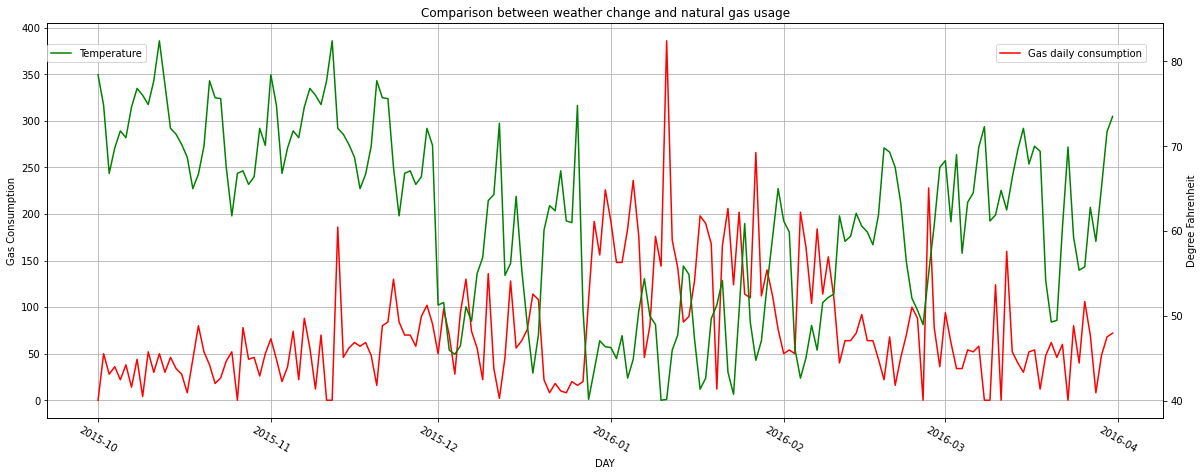

In [37]:
## choose one id from each cluster and plot the figure of its usage with weather
## the example is meter_id = 35
fig = plt.figure(figsize=(20,16)) # set the figure size

ax1 = plt.subplot(2,1,1)
plt.plot(x,y_diff,'-r', label = 'Gas daily consumption')
plt.grid(True)
plt.axis('tight')
plt.xlabel("DAY")
plt.ylabel('Gas Consumption')
plt.title("Comparison between weather change and natural gas usage")
plt.xticks(rotation=-30)
plt.legend(loc=[0.85,0.9])

ax2=ax1.twinx()

plt.plot(x,yw,'g', label = 'Temperature')
plt.ylabel("Degree Fahrenheit")
plt.legend(loc=[0,0.9])

plt.show()